In [84]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras import backend as K
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

In [85]:
data = pd.read_csv(filepath_or_buffer="./Data/growth_rate.csv", index_col="date")

In [86]:
# data.head()
# data.tail()
# data.info()

In [87]:
data = data.apply(pd.to_numeric, errors = "coerce")
#data.info()

In [88]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [89]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [125]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [126]:
data.columns

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [127]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [128]:
values

array([[ 0.00704504,  0.00124224, -0.00560538, ...,  0.00318379,
         0.00479325,  0.00235611],
       [ 0.00710283, -0.01116625, -0.01014656, ...,  0.00137046,
         0.001068  ,  0.00352586],
       [ 0.02463141, -0.02258469, -0.0261959 , ...,  0.01051646,
         0.01920341,  0.02392505],
       ...,
       [ 0.01085129,  0.01056338,  0.00961538, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [ 0.0105578 , -0.01045296, -0.0031746 , ..., -0.01375496,
        -0.00062024, -0.01495208],
       [-0.00631667,  0.02464789,  0.02547771, ..., -0.00136592,
         0.00265981,  0.00064868]], dtype=float32)

In [129]:
look_back = 5 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
7925  -0.004299   0.000000   0.000000   0.000871  -0.004520   0.006490   
7926  -0.005512  -0.010274  -0.009375  -0.022126   0.011167   0.001701   
7927  -0.030864  -0.017301  -0.022082  -0.016906  -0.004369   0.000283   
7928   0.018625   0.007042   0.012903  -0.000517   0.000203  -0.001697   
7929  -0.017327  -0.017483  -0.019108   0.001294   0.002478  -0.000567   

      var7(t-5)  var8(t-5)  var1(t-4)  var2(t-4)  ...  var7(t-1)  var8(t-1)  \
7925   0.002311   0.005479  -0.005512  -0.010274  ...  -0.007908   0.000128   
7926  -0.005852  -0.000649  -0.030864  -0.017301  ...   0.007524   0.001411   
7927   0.004103   0.006491   0.018625   0.007042  ...   0.002400   0.006019   
7928  -0.000355   0.005546  -0.017327  -0.017483  ...   0.000887  -0.003819   
7929  -0.007908   0.000128  -0.006560   0.000000  ...  -0.000620  -0.014952   

       var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)   var7(t)  \
7925 -0.006560  0.000000  0.000000  0.002067 -0.002472  0.001985  0.007524   
7926  0.015667  0.010676  0.012987 -0.024239 -0.004387 -0.005306  0.002400   
7927  0.010851  0.010563  0.009615 -0.011099 -0.008528  0.003058  0.000887   
7928  0.010558 -0.010453 -0.003175 -0.047969  0.013334 -0.013755 -0.000620   
7929 -0.006317  0.024648  0.025478 -0.001965  0.000772 -0.001366  0.002660   

       var8(t)  
7925  0.001411  
7926  0.006019  
7927 -0.003819  
7928 -0.014952  
7929  0.000649  

[5 rows x 48 columns]

In [130]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [131]:
# scaled = reframed.values
# scaled

In [132]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [133]:
# split into input and outputs
train_X, train_y = train[:, :-8], train[:, -8:]
test_X, test_y = test[:, :-8], test[:, -8:]

In [134]:
train_X.shape

(5547, 40)

In [135]:
test_y.shape

(2378, 8)

In [136]:
train_X = train_X.reshape((train_X.shape[0], look_back, 8))
test_X = test_X.reshape((test_X.shape[0], look_back, 8))
#train_y = train_y.reshape((train_y.shape[0], 1, 8))
#test_y = test_y.reshape((test_y.shape[0], 1, 8))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5547, 5, 8) (5547, 8) (2378, 5, 8) (2378, 8)


# Building the Model

In [137]:
train_y

array([[0.6315711 , 0.41849088, 0.59530929, ..., 0.4296785 , 0.67015511,
        0.31847226],
       [0.63574997, 0.43750505, 0.60814981, ..., 0.40643796, 0.72058476,
        0.36282892],
       [0.62390424, 0.47633862, 0.74397393, ..., 0.42491893, 0.36802818,
        0.24640902],
       ...,
       [0.63398232, 0.49159241, 0.73618725, ..., 0.33634613, 0.55375486,
        0.27363804],
       [0.72072793, 0.50614693, 0.67929274, ..., 0.4390921 , 0.65813045,
        0.31518243],
       [0.57945624, 0.44137931, 0.8478768 , ..., 0.40252204, 0.63900111,
        0.27540793]])

In [138]:
# model = Sequential()
# model.add(LSTM(units=100, return_sequences= True, input_shape=(train_X.shape[1],train_X.shape[2])))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100, return_sequences=True))
# model.add(LSTM(units=100))#, return_sequences= True, input_shape=(train_y.shape[1],8)))

# model.add(Dense(units=8))
# model.summary()

In [139]:
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.std(loss, axis=-1)

In [140]:
model = Sequential()

model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=100))
#model.add(Dropout(0.2))
#model.add(LSTM(units=100, return_sequences=True))
#model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(
    250,
    return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(train_X.shape[2], activation='linear'))
#model.add(Activation("linear"))
#opt = Nadam(lr=0.002)
#model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss=stock_loss)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 5, 100)            43600     
_________________________________________________________________
lstm_18 (LSTM)               (None, 250)               351000    
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2008      
Total params: 396,608
Trainable params: 396,608
Non-trainable params: 0
_________________________________________________________________


In [141]:
#model.compile(optimizer='adam', loss='mean_squared_error')
n_batch = 150#len(train_X)
history = model.fit(train_X, train_y, epochs=50, batch_size=n_batch, validation_data=(test_X, test_y))

Train on 5547 samples, validate on 2378 samples
Epoch 1/50
5547/5547 [==============================] - 3s 601us/step - loss: 0.0557 - val_loss: 0.0486
Epoch 2/50
5547/5547 [==============================] - 1s 229us/step - loss: 0.0418 - val_loss: 0.0467
Epoch 3/50
5547/5547 [==============================] - 1s 230us/step - loss: 0.0413 - val_loss: 0.0462
Epoch 4/50
5547/5547 [==============================] - 1s 228us/step - loss: 0.0410 - val_loss: 0.0472
Epoch 5/50
5547/5547 [==============================] - 1s 230us/step - loss: 0.0421 - val_loss: 0.0467
Epoch 6/50
5547/5547 [==============================] - 1s 227us/step - loss: 0.0406 - val_loss: 0.0464
Epoch 7/50
5547/5547 [==============================] - 1s 230us/step - loss: 0.0405 - val_loss: 0.0466
Epoch 8/50
5547/5547 [==============================] - 1s 232us/step - loss: 0.0405 - val_loss: 0.0463
Epoch 9/50
5547/5547 [==============================] - 1s 232us/step - loss: 0.0403 - val_loss: 0.0462
Epoch 10/50
5547

In [1]:
# from keras.callbacks import ModelCheckpoint

# weight_path="{}_weights.hdf5".format('8to8market_lstm_growth_rate_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = False)
# callbacks_list = [checkpoint]

# multi_model = Sequential()
# multi_model.add(LSTM(
#     input_shape=(train_X.shape[1],train_X.shape[2]),
#     return_sequences=True, units=train_X.shape[1]))

# multi_model.add(LSTM(
#     300,
#     return_sequences=True))
# #multi_model.add(TimeDistributed(Dense(number_of_variables)))
# multi_model.compile(loss="mse", optimizer="adam")
# multi_history = multi_model.fit(train_X, train_y, epochs=50, batch_size=150, validation_data=(test_X, test_y),
#                                 verbose=0, shuffle=False)#, callbacks = callbacks_list)




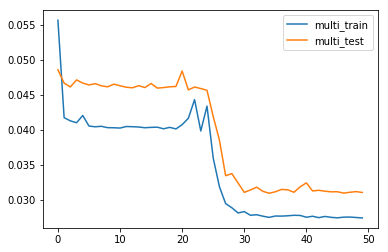

In [142]:
#multi_history = model
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [143]:
test_X.shape

(2378, 5, 8)

In [144]:
from keras.models import load_model

#multi_model = load_model("8to8market_lstm_growth_rate_model_weights.hdf5")
multi_model = model
yhat = multi_model.predict(test_X)

In [145]:
test_y[:,0]

array([0.68676762, 0.68101314, 0.71921599, ..., 0.67251477, 0.67159895,
       0.61894353])

In [146]:
yhat[:,0]

array([0.6191972 , 0.6213716 , 0.6231974 , ..., 0.6199109 , 0.6205694 ,
       0.61952114], dtype=float32)

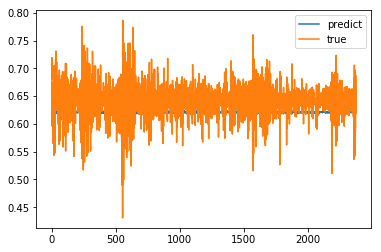

In [147]:
pyplot.plot(yhat[:,0], label='predict')
pyplot.plot(test_y[:,0], label='true')
pyplot.legend()
pyplot.show()

#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

inv_yhat.shape

#inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat[-1]

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8:]

inv_yhat[0]

#reshape actual
test_y = test_y.reshape((test_y.shape[0], test_y.shape[2]))

test_y.shape

inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y = scaler.inverse_transform(inv_y)

inv_y[-1]

#inv_y[:,-8:].shape

inv_y = inv_y[:,-8:]

inv_y[:,0].shape

test_y[:,0].shape

#rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
#print('Test RMSE: %.3f' % rmse)

In [148]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))

#yhat.shape

#yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

#test_X.shape

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

#inv_yhat.shape

inv_yhat = scaler.inverse_transform(inv_yhat)

#inv_yhat[:,-8:].shape

inv_yhat = inv_yhat[:,-8:]

#inv_yhat.shape

In [149]:
inv_y = concatenate((test_X[:, :], test_y), axis=1)

#inv_y.shape

inv_y = scaler.inverse_transform(inv_y)

inv_y[:,-8:].shape

inv_y = inv_y[:,-8:]

In [150]:
inv_y

array([[ 0.0154189 ,  0.01041667, -0.01078167, ...,  0.00165354,
         0.01841911,  0.00690874],
       [ 0.01357476, -0.05154639, -0.05449591, ..., -0.01650814,
        -0.01250517, -0.01260571],
       [ 0.02581761,  0.05434782,  0.06916427, ..., -0.01334825,
         0.01025641, -0.01745314],
       ...,
       [ 0.01085129,  0.01056338,  0.00961538, ...,  0.0030581 ,
         0.00088684, -0.00381922],
       [ 0.0105578 , -0.01045296, -0.0031746 , ..., -0.01375496,
        -0.00062024, -0.01495208],
       [-0.00631667,  0.02464789,  0.02547771, ..., -0.00136592,
         0.00265981,  0.00064868]])

In [151]:
inv_yhat

array([[-0.00623538, -0.01882913, -0.00224473, ...,  0.00011592,
        -0.00090685, -0.0012806 ],
       [-0.00553853, -0.01759921, -0.00165758, ...,  0.00023358,
        -0.00094884, -0.00103444],
       [-0.00495344, -0.0159717 , -0.00089348, ...,  0.00056424,
        -0.00105572, -0.00078361],
       ...,
       [-0.00600665, -0.01802574, -0.00221497, ...,  0.0001388 ,
        -0.00116969, -0.00083683],
       [-0.00579562, -0.01772933, -0.00200514, ...,  0.00021734,
        -0.00102942, -0.000816  ],
       [-0.00613156, -0.01813463, -0.00217241, ...,  0.00012924,
        -0.00104778, -0.00100578]])

In [152]:
rmse = sqrt(mean_squared_error(yhat[:,0], test_y[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.035


In [153]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.011


In [154]:
inv_y[:,0]

array([ 0.0154189 ,  0.01357476,  0.02581761, ...,  0.01085129,
        0.0105578 , -0.00631667])

In [155]:
inv_yhat[:,0]

array([-0.00623538, -0.00553853, -0.00495344, ..., -0.00600665,
       -0.00579562, -0.00613156])

In [156]:
test_y[:,0]

array([0.68676762, 0.68101314, 0.71921599, ..., 0.67251477, 0.67159895,
       0.61894353])

In [157]:
yhat[:,0]

array([0.6191972 , 0.6213716 , 0.6231974 , ..., 0.6199109 , 0.6205694 ,
       0.61952114], dtype=float32)

In [158]:
# predictDates = data.tail(len(inv_y)).index
# actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
# multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
# py.iplot([multi_predict_chart, actual_chart])


predictDates = data.tail(len(test_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart])

In [159]:
py.iplot([multi_predict_chart, actual_chart])